In [10]:
%matplotlib inline
import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nengo_dl
from nengo.utils.ipython import hide_input

In [11]:
import matplotlib
matplotlib.font_manager._rebuild()
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = fig_size
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size' : 16}
plt.rc('font', **font)
plt.subplots_adjust(bottom=0.0, right=0.8, top=1.0)

<Figure size 1200x800 with 0 Axes>

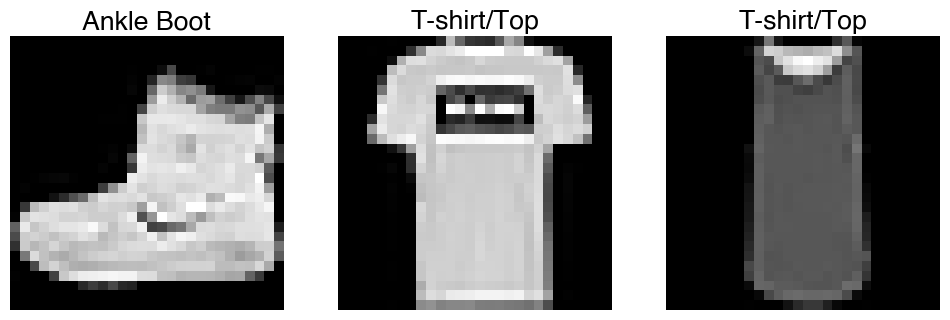

In [12]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# normalize images so values are between 0 and 1
#x_train = x_train / 255.0
#x_test = x_test / 255.0

# flatten images from 28x28 to 784
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))


# initialize the label names
labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
# number of classes
num_classes = len(labelNames)

# show some examples
length = 3
plt.figure()
for i in range(length):
    plt.subplot(1, length, i+1)
    plt.imshow(np.reshape(x_train[i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(labelNames[y_train[i]]))
plt.savefig('images/example_images.png', bbox_inches='tight')

In [36]:
# Convolutional Spiking Neural Network

model = nengo.Network()
with model:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since stateful behaviour is not required here
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=32, kernel_size=3))(inp, shape_in=(28, 28, 1))
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)

    # add the second convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=64, strides=2, kernel_size=3))(x, shape_in=(26, 26, 32))
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)
    
    # add the third convolutional layer
    x = nengo_dl.Layer(tf.keras.layers.Conv2D(
        filters=128, strides=2, kernel_size=3))(x, shape_in=(12, 12, 64))
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    # we'll create two different output probes, one with a filter
    # (for when we're simulating the network over time and
    # accumulating spikes), and one without (for when we're
    # training the network using a rate-based approximation)
    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

Show Input for executing Fully Connected SNN instead of Convolutional SNN

In [32]:
# Fully Connected Spiking Neural Network

model = nengo.Network()
with model:
    # set some default parameters for the neurons that will make
    # the training progress more smoothly
    model.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    model.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    model.config[nengo.Connection].synapse = None
    neuron_type = nengo.LIF(amplitude=0.01)

    # this is an optimization to improve the training speed,
    # since stateful behaviour is not required here
    nengo_dl.configure_settings(stateful=False)

    # the input node that will be used to feed in input images
    inp = nengo.Node(np.zeros(28 * 28))

    # add the first dense layer
    x = nengo_dl.Layer(tf.keras.layers.Dense(64))(inp)
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)

    # add the second dense layer
    x = nengo_dl.Layer(tf.keras.layers.Dense(64))(x)
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)
    
    # add the third dense layer
    x = nengo_dl.Layer(tf.keras.layers.Dense(64))(x)
    x = nengo_dl.Layer(neuron_type)(x)
    
    x = nengo_dl.Layer(tf.keras.layers.Dropout(0.25))(x)

    # linear readout
    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")
hide_input()

In [14]:
minibatch_size = 200
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               


c:\users\unaig\desktop\experimentacion\ai\nengodl\nengo-dl\nengo_dl\simulator.py:1941: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x21126df5048>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


In [15]:
x_train = x_train[:, None, :]
y_train = y_train[:, None, None]

n_steps = 100
x_test = np.tile(x_test[:, None, :],
                      (1, n_steps, 1))
y_test = np.tile(y_test[:, None, None],
                      (1, n_steps, 1))

In [19]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(
        y_true[:, -1], y_pred[:, -1])

In [ ]:
# note that we use `out_p_filt` when testing (to reduce the spike noise)
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy before training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

In [8]:
sim.compile(
    optimizer=tf.optimizers.RMSprop(0.001),
    loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)}
)
sim.fit(x_train, {out_p: y_train}, epochs=30)

Train on 60000 samples
Epoch 1/30
60000/60000 [==============================] - 5s 89us/sample - loss: 1.3123 - out_p_loss: 1.3123
Epoch 2/30
60000/60000 [==============================] - 4s 61us/sample - loss: 0.8160 - out_p_loss: 0.8160
Epoch 3/30
60000/60000 [==============================] - 4s 61us/sample - loss: 0.7410 - out_p_loss: 0.7410
Epoch 4/30
60000/60000 [==============================] - 4s 60us/sample - loss: 0.6924 - out_p_loss: 0.6924
Epoch 5/30
60000/60000 [==============================] - 4s 61us/sample - loss: 0.6656 - out_p_loss: 0.6656
Epoch 6/30
60000/60000 [==============================] - 4s 61us/sample - loss: 0.6283 - out_p_loss: 0.6283
Epoch 7/30
60000/60000 [==============================] - 4s 63us/sample - loss: 0.6112 - out_p_loss: 0.6112
Epoch 8/30
60000/60000 [==============================] - 4s 62us/sample - loss: 0.5857 - out_p_loss: 0.5857
Epoch 9/30
60000/60000 [==============================] - 4s 61us/sample - loss: 0.5727 - out_p_loss: 0.5

In [10]:
# save the parameters to file
sim.save_params("./params/fashion-mnist_params_dense")

In [11]:
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

accuracy after training: 0.8391000044345855


In [257]:
sim.close()

### Load params

In [40]:
sim = nengo_dl.Simulator(model, minibatch_size=minibatch_size)
sim.load_params("./params/fashion-mnist_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:01                                               


c:\users\unaig\desktop\experimentacion\ai\nengodl\nengo-dl\nengo_dl\simulator.py:1941: RuntimeWarning: Simulator with model=Model: <Network (unlabeled) at 0x212cf726da0>, dt=0.001000 was deallocated while open. Simulators should be closed manually to ensure resources are properly freed.
  RuntimeWarning,


In [17]:
(_, _), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_test = x_test.reshape((x_test.shape[0], -1))

n_steps = 100
x_test = np.tile(x_test[:, None, :],
                      (1, n_steps, 1))
y_test = np.tile(y_test[:, None, None],
                      (1, n_steps, 1))

In [25]:
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:",
sim.evaluate(x_test, {out_p_filt: y_test}, verbose=0)["loss"])

accuracy after training: 0.8391000044345855


In [41]:
sim.compile(loss={out_p_filt: classification_accuracy})
data = sim.predict(x_test[:minibatch_size])

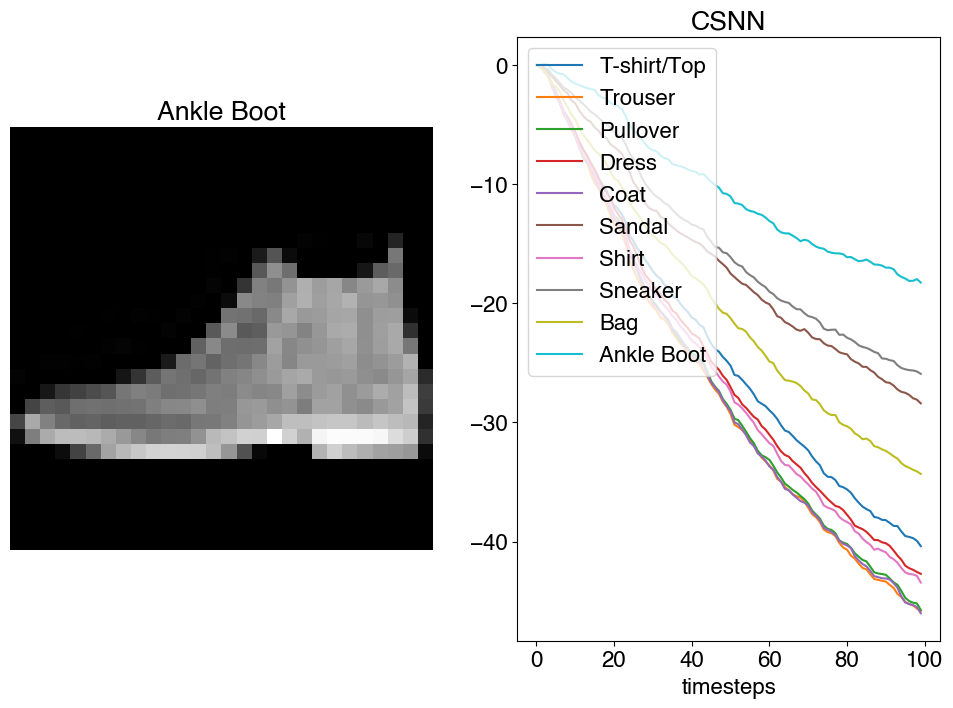

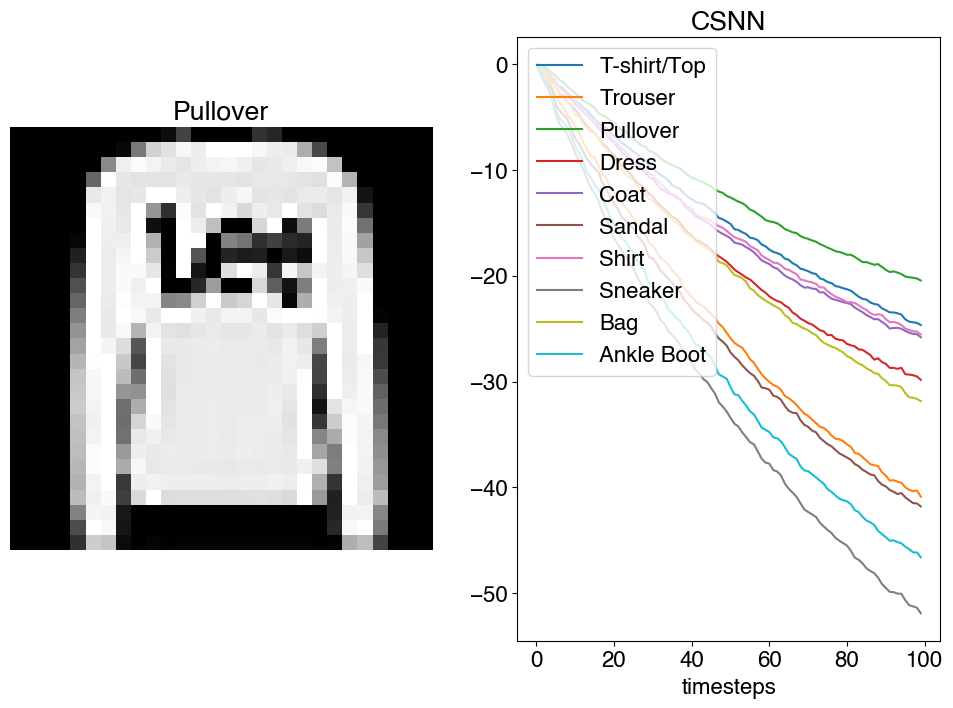

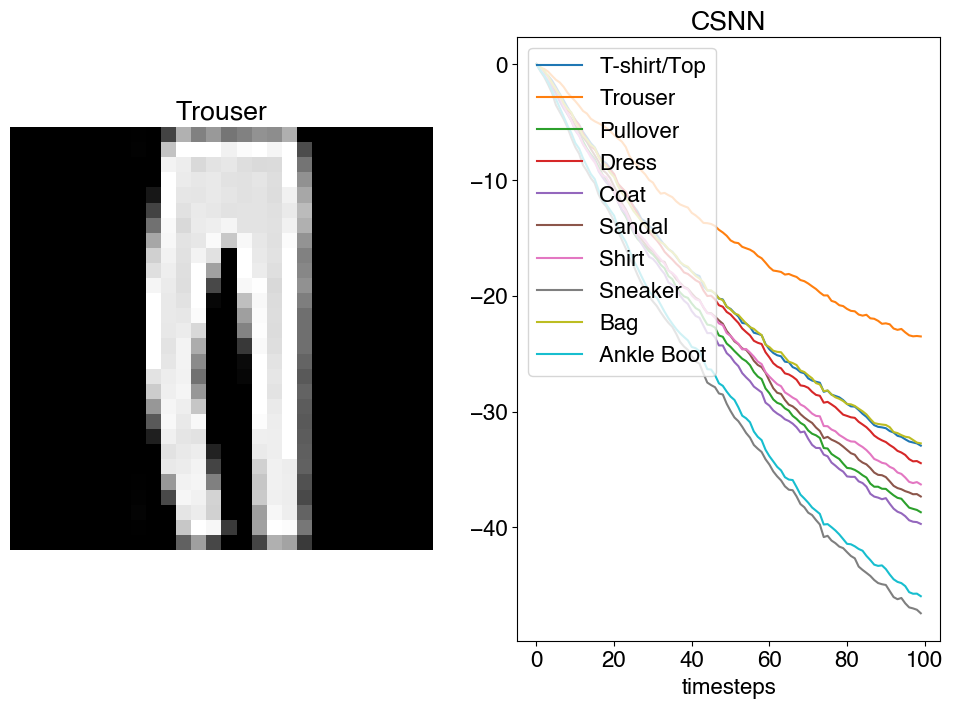

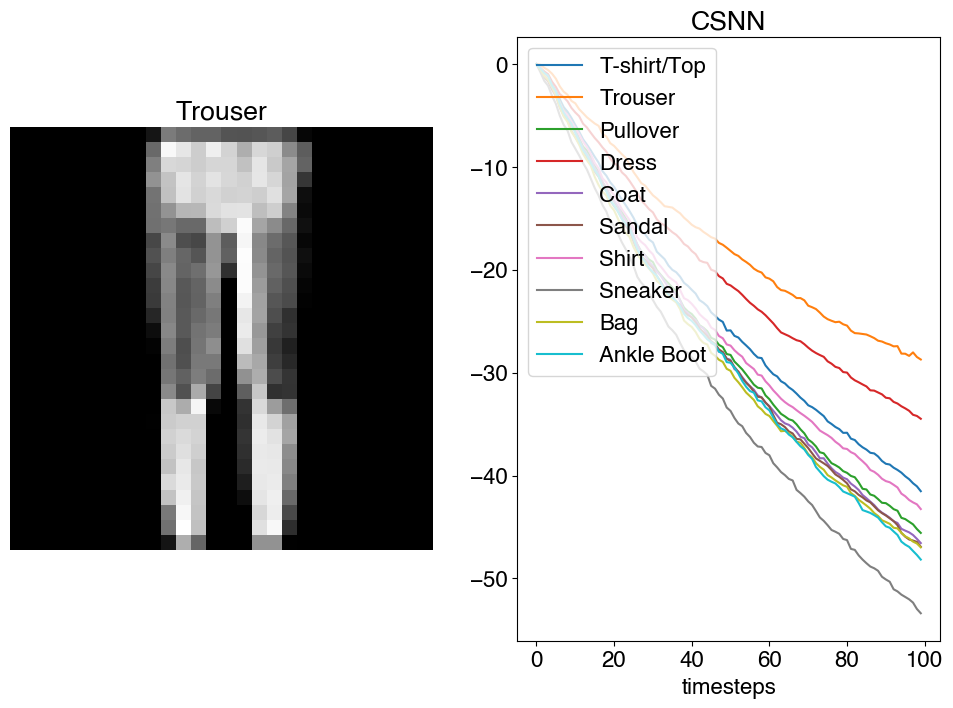

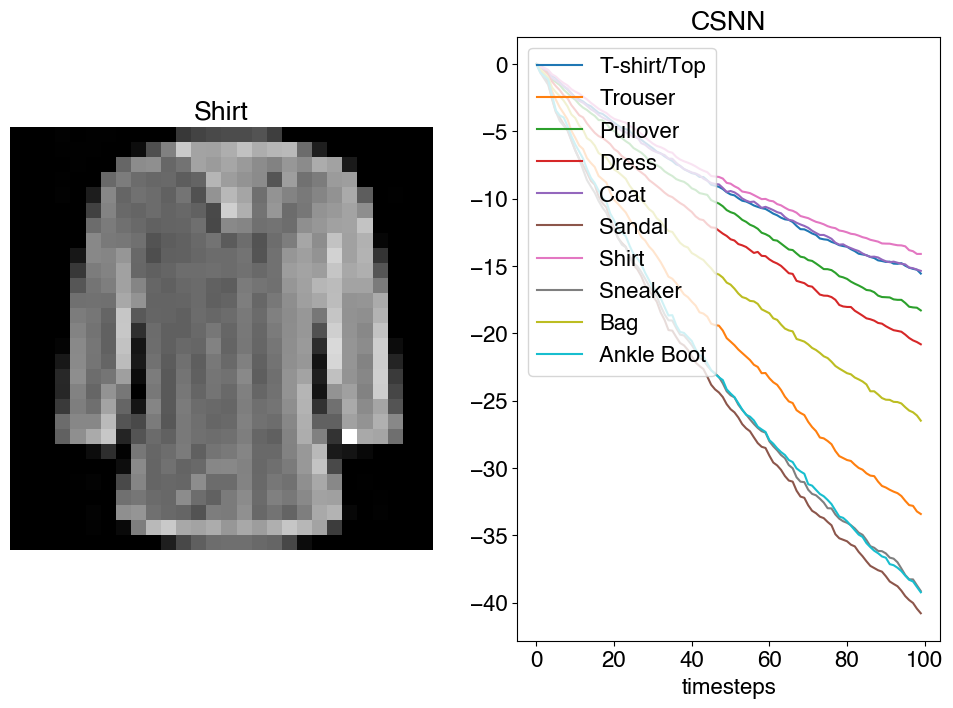

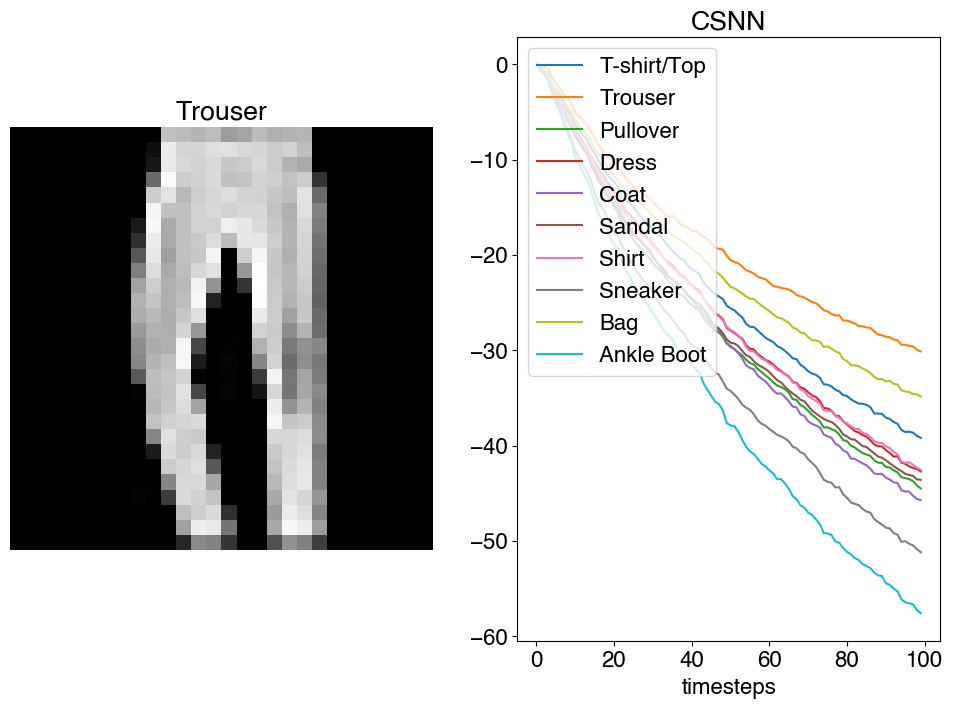

In [42]:
# initialize the label names
labelNames = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
              "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
for i in range(6):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title(labelNames[y_test[i, 0][0]])
    plt.imshow(x_test[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(data[out_p_filt][i])
    plt.legend([str(labelNames[i]) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")
    plt.title("CSNN")
    plt.savefig('images/prediction{}_2.png'.format(i+1), bbox_inches='tight')

In [ ]:
sim.close()